# Sign Language Transfer Learning

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
import shutil
tf.__version__

'2.6.2'

In [2]:
if 'ASL' in os.listdir('/kaggle/working/'):
    print('ASL exists')
else:
    shutil.copytree('/kaggle/input/asl-dataset/asl_dataset','/kaggle/working/ASL') 
    print('ASL copytree')
    
!rm -rf /kaggle/working/ASL/asl_dataset

ASL copytree


# Preprocessing with ImageDataGenerator

### Prepare ImageDataGenerator
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [3]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                            #rotation_range=90,
                            brightness_range=(0.5,1), 
                            #shear_range=0.2, 
                            #zoom_range=0.2,
                            channel_shift_range=0.2,
                            #horizontal_flip=True,
                            #vertical_flip=True,
                            rescale=1./255,
                            validation_split=0.3)

### Prepare img_generator_flow

In [4]:
root_dir = '/kaggle/working/ASL'

img_generator_flow_train = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset="training")

img_generator_flow_valid = img_generator.flow_from_directory(
    directory=root_dir,
    target_size=(224,224),
    batch_size=32,
    shuffle=True,
    subset="validation")

Found 1761 images belonging to 36 classes.
Found 754 images belonging to 36 classes.


In [5]:
data_dir = '/kaggle/working/ASL'
Names0 = os.listdir(data_dir)
Names=sorted(Names0)
print(Names)
print(len(Names))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
36


In [6]:
N=list(range(len(Names)))
normal_mapping=dict(zip(Names,N))
reverse_mapping=dict(zip(N,Names))

### Visualize a batch of images

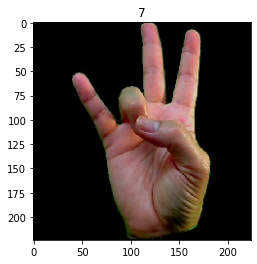

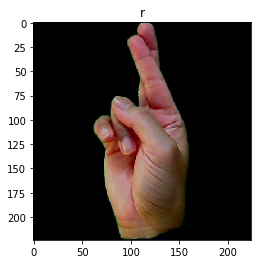

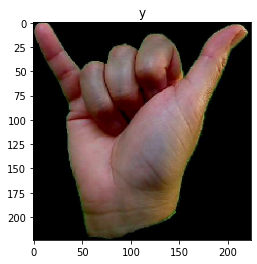

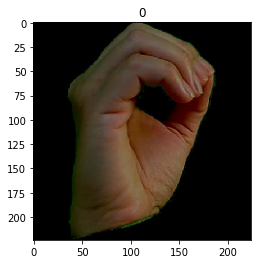

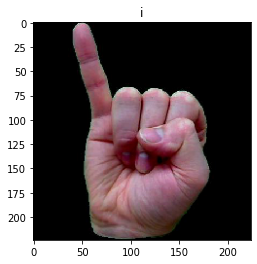

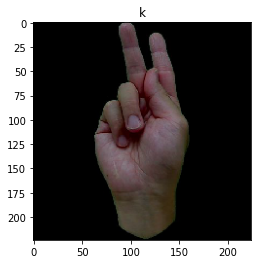

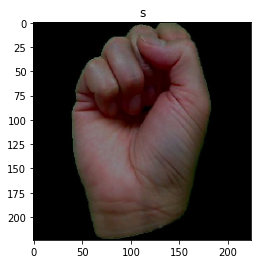

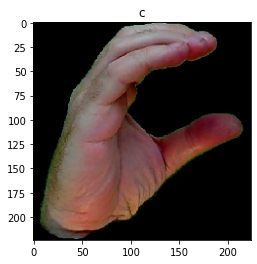

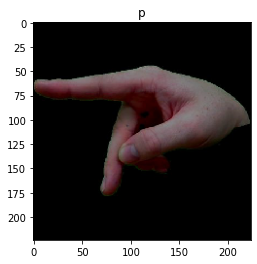

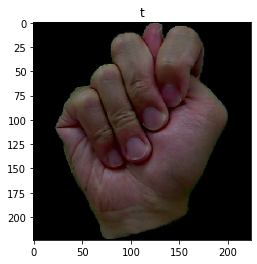

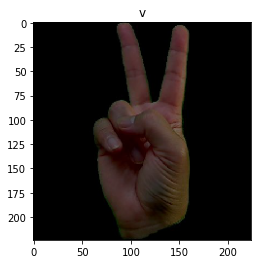

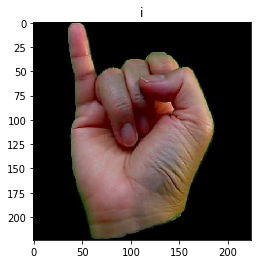

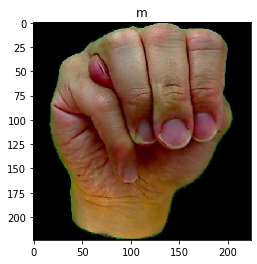

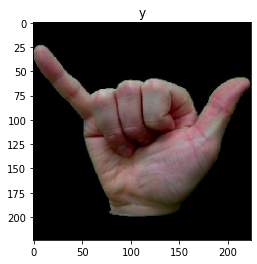

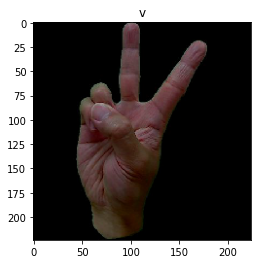

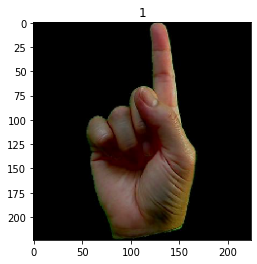

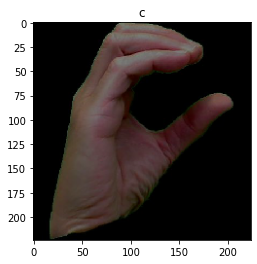

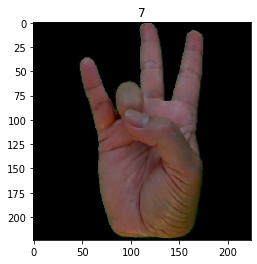

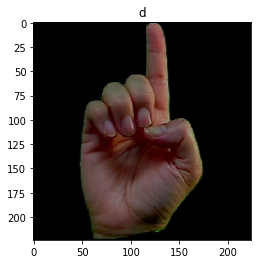

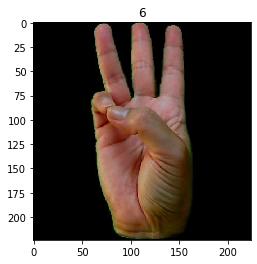

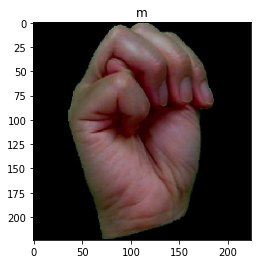

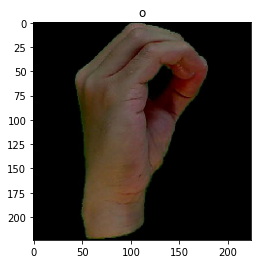

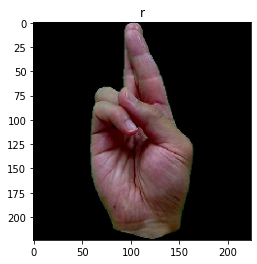

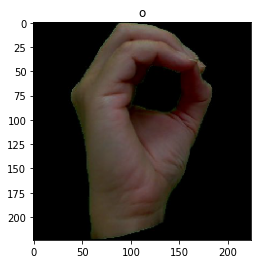

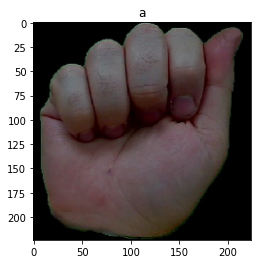

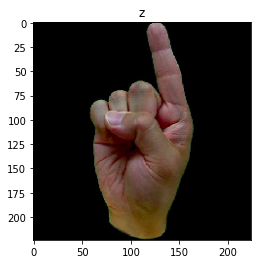

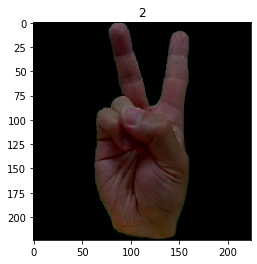

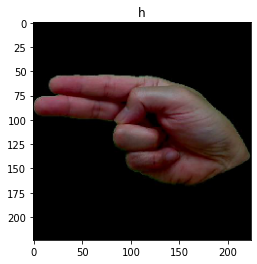

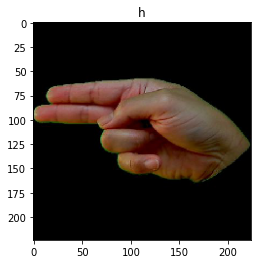

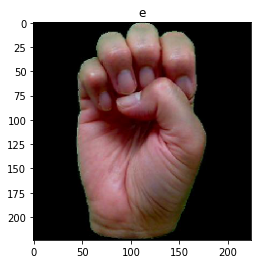

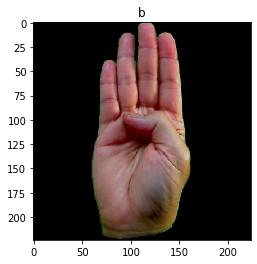

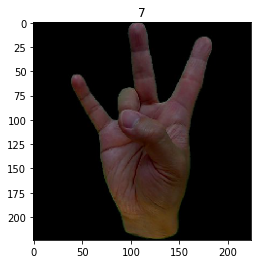

In [7]:
imgs, labels = next(iter(img_generator_flow_train))
for img, label in zip(imgs, labels):
    value=np.argmax(label)
    labelname=reverse_mapping[value]
    plt.imshow(img)
    plt.title(labelname)
    plt.show()

# Transfer Learning 

### Import a pretrained model
https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3

In [8]:
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

2022-01-04 11:19:42.571577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 11:19:42.665994: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 11:19:42.666719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 11:19:42.668631: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

87924736/87910968 [==============================] - 0s 0us/step


### Set the weights of the imported model

In [9]:
base_model.trainable = False

### Create model

In [10]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(Names), activation="softmax")
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 36)                294948    
Total params: 22,097,732
Trainable params: 294,948
Non-trainable params: 21,802,784
_________________________________________________________________


### Compile model

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

### Train the model

In [13]:
model.fit(img_generator_flow_train, 
          validation_data=img_generator_flow_valid, 
          steps_per_epoch=16, epochs=64) #8,64

2022-01-04 11:19:49.630549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/64


2022-01-04 11:19:54.123016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


16/16 [==============================] - 19s 605ms/step - loss: 5.2763 - categorical_accuracy: 0.2578 - val_loss: 2.7958 - val_categorical_accuracy: 0.5517
Epoch 2/64
16/16 [==============================] - 7s 463ms/step - loss: 1.8489 - categorical_accuracy: 0.6289 - val_loss: 1.3156 - val_categorical_accuracy: 0.6485
Epoch 3/64
16/16 [==============================] - 8s 494ms/step - loss: 0.8061 - categorical_accuracy: 0.7734 - val_loss: 1.0488 - val_categorical_accuracy: 0.7268
Epoch 4/64
16/16 [==============================] - 7s 474ms/step - loss: 0.3618 - categorical_accuracy: 0.8926 - val_loss: 0.7672 - val_categorical_accuracy: 0.7984
Epoch 5/64
16/16 [==============================] - 7s 467ms/step - loss: 0.3209 - categorical_accuracy: 0.9168 - val_loss: 0.7882 - val_categorical_accuracy: 0.7838
Epoch 6/64
16/16 [==============================] - 7s 480ms/step - loss: 0.5922 - categorical_accuracy: 0.8919 - val_loss: 1.3160 - val_categorical_accuracy: 0.7454
Epoch 7/64
16/

### Visualize accuracy and loss

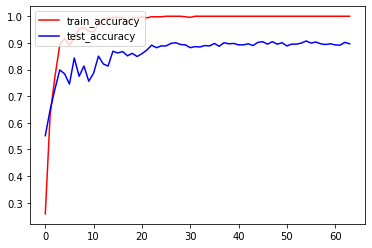

In [14]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

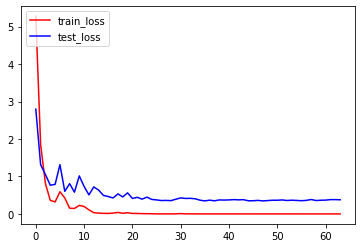

In [15]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

# Interpretation with Grad Cam


### Create imgs and labels

In [16]:
imgs, labels = next(iter(img_generator_flow_valid))
#timgs, tlabels = next(iter(img_generator_flow_test))

In [17]:
for layer in model.layers:
    print(layer.name)

inception_v3
max_pooling2d_4
flatten
dense


In [18]:
base_model = model.layers[0]

In [19]:
tf.keras.utils.plot_model(base_model, show_shapes=True, show_layer_names=True)

In [20]:
for layer in base_model.layers:
    print(layer.name)

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [21]:
last_conv_layer_name = "mixed10"
classifier_layer_names = [layer.name for layer in model.layers][1:]

In [22]:
# We start by setting up the dependencies we will use

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### make_gradcam_heatmap

In [23]:
# The Grad-CAM algorithm
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(base_model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

### Predict

In [24]:
# Print what the top predicted class is
preds = model.predict(imgs)
pred_labels = tf.argmax(preds, axis = -1)

print("Prediction output:", preds)
print("Predicted label:", pred_labels)

Prediction output: [[3.8074763e-08 6.6365735e-09 6.6119736e-07 ... 3.1317027e-10
  5.0729255e-08 8.8122283e-09]
 [6.2117806e-07 6.8000003e-07 5.5764065e-08 ... 1.5718189e-07
  9.8734372e-06 5.2846381e-06]
 [2.9256579e-09 2.2014066e-07 1.0471947e-02 ... 3.8968300e-09
  2.5340972e-08 1.2719447e-05]
 ...
 [2.5428270e-07 1.9947690e-07 2.3771693e-04 ... 2.0130098e-07
  1.9552739e-04 2.6475749e-04]
 [1.7226104e-05 6.6364533e-05 1.1428792e-03 ... 1.3025560e-05
  1.2740337e-07 1.3572678e-07]
 [2.1937419e-06 2.0134516e-06 2.8875240e-08 ... 2.1744603e-08
  9.1797415e-07 3.5551382e-06]]
Predicted label: tf.Tensor(
[11 22  6  9 11 16  1  2  9 27 18 15  4 29 35 20  3 35  9  5 33  8 18 27
  5 12  5  4 25  3 20 14], shape=(32,), dtype=int64)


### Create heatmap

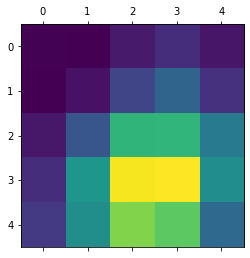

In [25]:
# Generate class activation heatmap
heatmaps = []

for img in imgs:
    heatmap = make_gradcam_heatmap(
    tf.expand_dims(img,axis=0),
        base_model, model, 
        last_conv_layer_name, 
        classifier_layer_names
  )
    heatmaps.append(heatmap)


# Display heatmap
plt.matshow(heatmaps[0])
plt.show()


### Predicted label and heatmap

Predicted label: b
True label: b


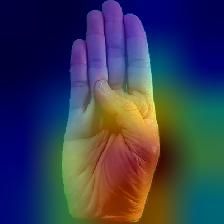

Predicted label: m
True label: m


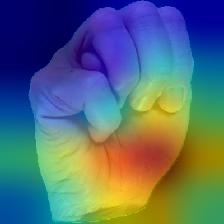

Predicted label: 6
True label: v


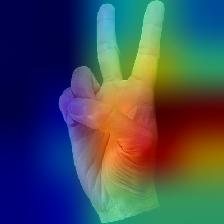

Predicted label: 9
True label: 9


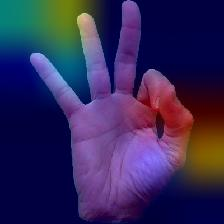

Predicted label: b
True label: b


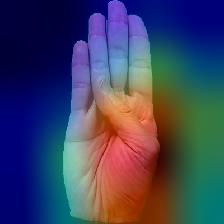

Predicted label: g
True label: g


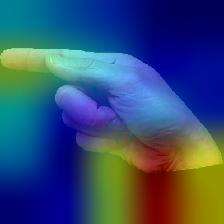

Predicted label: 1
True label: 1


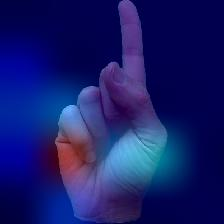

Predicted label: 2
True label: 2


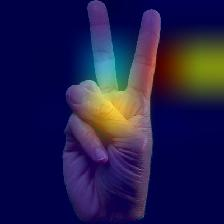

Predicted label: 9
True label: 9


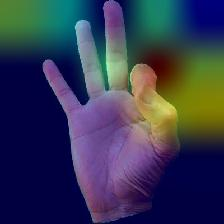

Predicted label: r
True label: r


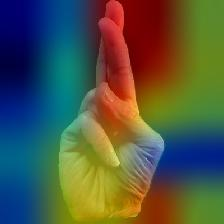

Predicted label: i
True label: i


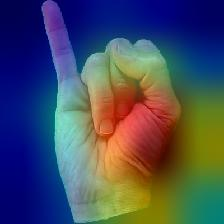

Predicted label: f
True label: f


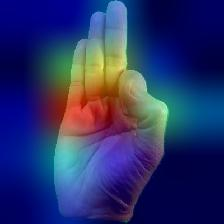

Predicted label: 4
True label: 4


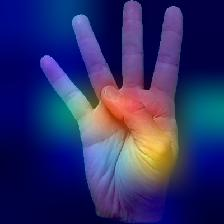

Predicted label: t
True label: t


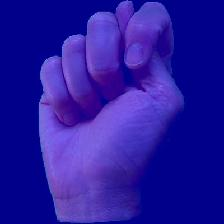

Predicted label: z
True label: z


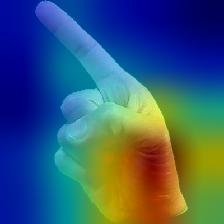

Predicted label: k
True label: k


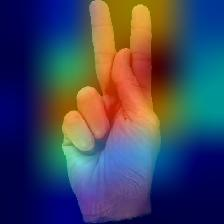

Predicted label: 3
True label: 3


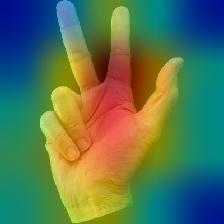

Predicted label: z
True label: z


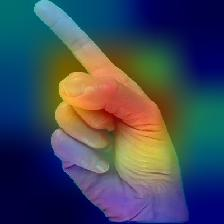

Predicted label: 9
True label: 9


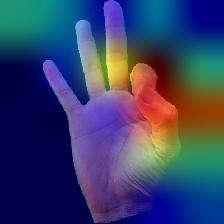

Predicted label: 5
True label: 5


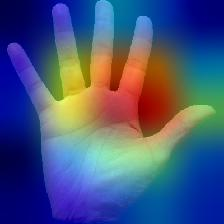

Predicted label: x
True label: x


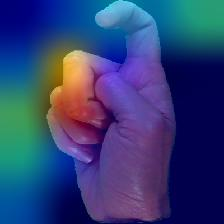

Predicted label: 8
True label: 8


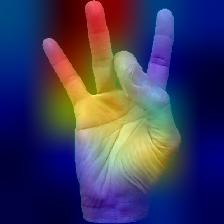

Predicted label: i
True label: m


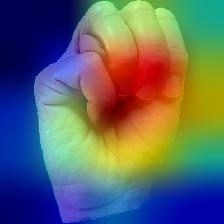

Predicted label: r
True label: r


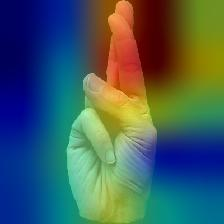

Predicted label: 5
True label: 5


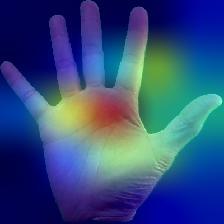

Predicted label: c
True label: c


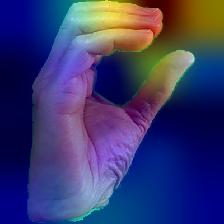

Predicted label: 5
True label: 5


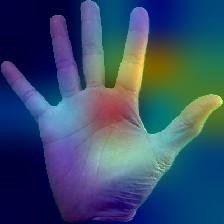

Predicted label: 4
True label: 4


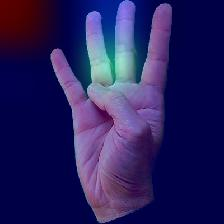

Predicted label: p
True label: p


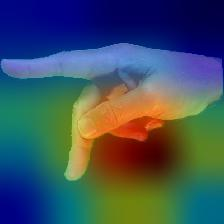

Predicted label: 3
True label: 3


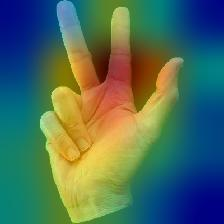

Predicted label: k
True label: k


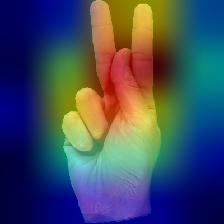

Predicted label: e
True label: e


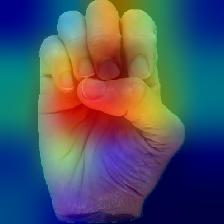

In [26]:
from pathlib import Path

for img, pred_label, true_label, heatmap in zip(imgs, pred_labels, labels, heatmaps): 
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.003 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    save_path = "saved_img.jpg"
    superimposed_img.save(save_path)

    # Display Grad CAM
    pred_file_path = np.argmax(img_generator_flow_valid.labels == pred_label)
    pred_label_name = Path(img_generator_flow_valid.filepaths[pred_file_path]).parent.name

    true_file_path = np.argmax(img_generator_flow_valid.labels == tf.argmax(true_label))
    true_label_name = Path(img_generator_flow_valid.filepaths[true_file_path]).parent.name

    print("Predicted label:",pred_label_name)
    print("True label:", true_label_name)

    display(Image(save_path))

In [27]:
LABEL=[]
for item in labels:   
    LABEL+=[np.argmax(item)]
PRED=pred_labels.numpy().tolist()

In [28]:
print(LABEL)
print(PRED)

[11, 22, 31, 9, 11, 16, 1, 2, 9, 27, 18, 15, 4, 29, 35, 20, 3, 35, 9, 5, 33, 8, 22, 27, 5, 12, 5, 4, 25, 3, 20, 14]
[11, 22, 6, 9, 11, 16, 1, 2, 9, 27, 18, 15, 4, 29, 35, 20, 3, 35, 9, 5, 33, 8, 18, 27, 5, 12, 5, 4, 25, 3, 20, 14]


In [29]:
from sklearn.metrics import classification_report
print(classification_report(LABEL,PRED))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         3
           6       0.00      0.00      0.00         0
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         1
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         1
          18       0.50      1.00      0.67         1
          20       1.00      1.00      1.00         2
          22       1.00      0.50      0.67         2
          25       1.00      1.00      1.00         1
          27       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
pip list


Package                            Version
---------------------------------- -------------------
absl-py                            0.13.0
aiohttp                            3.7.4.post0
alabaster                          0.7.12
altair                             4.1.0
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
apyori                             1.1.2
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astor                              0.8.1
astroid                            2.5
astropy                            4.2.1
astunparse                         1.6.3
async-generator                    1.10
async-timeout                      3.0.1
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                         